# Жолковский Евгений

# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2 - Алгоритмы кластеризации


###### Задание 1 (4 балла)
Реализовать алгоритм кластеризации, который относится к вашему варианту. Проверить работоспособность алгоритма на "Iris". Сравните свой алгоритм кластеризации с алгоритмом из scikit-learn по времени выполнения, использую timeit. Ваша реализация не должна работать сильно дольше, а в идеале должна быть даже немного быстрее.

###### Задание 2 (2 балла)
Выбрать, имплементировать и использовать критерий качества

###### Задание 3 (3балла)
Применить алгоритм кластеризации к данным по странам.   
Подход следующий: фиксируем год, для каждой страны берём индикаторы по зафиксированному году, кластеризуем по индикаторам.   
Разбиение должно быть объяснимым, в противном случае, скорее всего нужно лучше настроить параметры кластеризации.   
Данные нужно скачать тут https://data.worldbank.org/data-catalog/world-development-indicators.   
Также необходимо показать, какие страны попали в общий кластер.
изуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время.

###### Задание 4 (1 балл)
Опишите в выводе почему и какие страны попали в общий кластер.

## 1. Алгоритм кластеризации Hierarchical clustering

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt
import mpl_toolkits.basemap as bm

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
## Задание 1

from scipy.spatial.distance import cdist

from sklearn.base import BaseEstimator, ClusterMixin

class Clustering(BaseEstimator, ClusterMixin):

    def __init__(self, linkage='single', k=3):
       
        self.k = k
        self.Nclusters = 0
        self.linkage = linkage
        dist = np.zeros(10)
        self.L = np.zeros(1)
        self.dim = 1
        self.Npoints = 1
        self.y = np.zeros(1)
        self.L = np.zeros(1)
        self.c = np.zeros(1)
        self.Z = []
        
    def distance(self, A, B):
    
        D = 0
        for i in xrange(self.dim):
            D = D +(A[i] - B[i])**2
            
        return sqrt(D)
          
        
    def silhoette(self, X, labels):
        dist = cdist(X,X)
        a = np.zeros(self.Npoints)
        b = np.zeros(self.Npoints)
        s = np.zeros(self.Npoints)
        #идем по точкам
        for i in xrange(self.Npoints):
          
            #принадлежащие кластеру
            if self.c[self.y[i]] > 1:
                a[i] = sum(dist[i, self.y == self.y[i]]) / (self.c[ self.y[i] ] - 1)
            #непринадлежащие кластеру
            b[i] = sum(dist[i, self.y != self.y[i]]) / (self.Npoints - self.c[self.y[i]])

            
            if (a[i] != 0) or (b[i] != 0):
                s[i] = (b[i] - a[i]) / max((a[i] , b[i]))
            
        return s.mean()
     
    def fit(self, X):
        
        self.Npoints = X.shape[0] #число точек
        self.dim = X.shape[1] #число параметров
        dist = np.zeros((self.Npoints, self.Npoints)) #матрица расстояний
        dist[:] = np.nan
        self.y = np.arange(self.Npoints) #принадлежность к кластеру
        self.L = np.zeros(self.Npoints) #level of clustering
        self.c = np.ones(self.Npoints*2) #размер кластера
        self.Nclusters = self.Npoints
        
        #расстояния между кластерами
        dist = cdist(X,X)
        for i in xrange(self.Npoints):
            dist[i,i] = np.nan
            
            
        for m in xrange(self.Npoints - self.k):
            #ищем минимальное
            ind = np.unravel_index(np.nanargmin(dist), dist.shape) #координаты минимального значения (k,m)

            k = ind[0]
            l = ind[1]
            

            #print self.y[k],  self.y[l], " : ",k, l
   
            self.L[m] = dist[ind] #уровень кластеризации
            dist[ind] = np.nan
        
            cl1, cl2 = self.y[[l,k]]
            
            for i in xrange(self.Npoints):
                
                if self.linkage == 'single':
                    dist[k,i] = min(dist[k,i], dist[l,i])

                elif self.linkage == 'complete':
                    dist[k,i] = max(dist[k,i], dist[l,i])
                
                elif self.linkage == 'average':
                    dist[k,i] = (dist[k,i]*self.c[cl1] + dist[l,i]*self.c[cl2]) / (self.c[cl1] + self.c[cl2])
            
            dist[:,k] = dist[k,:]
            dist[:,l] = np.nan
            dist[l,:] = np.nan
                  
            #новый кластер в старой матрице 
        
            self.Z.append([self.y[k], self.y[l], self.L[m], 2])
               
            for i in xrange(self.Npoints):
                if self.y[i] == cl1 or self.y[i] == cl2: #если принадлежит кластеру
                    self.y[i] = self.Npoints + m #меняем индекс кластера
                    
            #объединяем
            self.c[k] = self.c[k] + self.c[l]
            self.c[self.Npoints + m] = self.c[cl1] + self.c[cl2]
            self.c[cl1] = 0
            self.c[cl2] = 0
            self.Nclusters = self.Nclusters - 1
            


    def predict(self):
        return self.y
    
    def Level(self):
        return self.L
    
    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.predict()
    
    def dendrogram(self):
        return self.Z

In [3]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=True, random_state=221)
np.random.shuffle(X)

### Single:

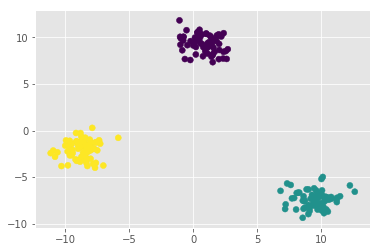

In [4]:
CL_single = Clustering(linkage='single', k=3)
c = CL_single.fit(X)
y_single = CL_single.predict()
plt.scatter(X[:,0], X[:,1], c=y_single)
plt.show()


### Complete:

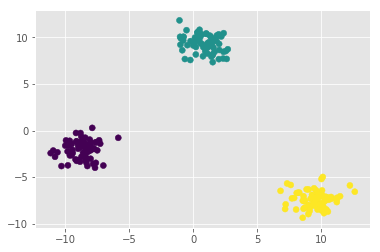

In [5]:
CL_complete = Clustering(linkage='complete', k=3)
c = CL_complete.fit(X)
y_complete = CL_complete.predict()
plt.scatter(X[:,0], X[:,1], c=y_complete)
plt.show()

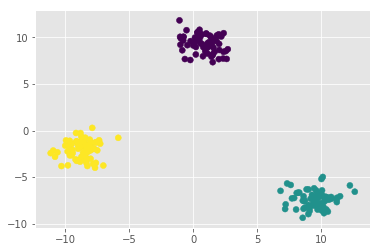

In [6]:
CL_average = Clustering(linkage='average', k=3)
c = CL_average.fit(X)
y_average = CL_average.predict()
plt.scatter(X[:,0], X[:,1], c=y_average)
plt.show()

### Дендрограмма

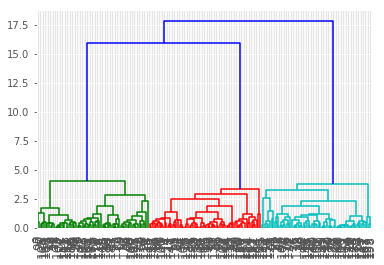

In [7]:
from scipy.cluster.hierarchy import dendrogram, linkage


CL = Clustering(linkage='average', k=1)
CL.fit(X)
dendrogram(CL.dendrogram(), leaf_rotation=90., leaf_font_size=12.,)
plt.show()

## 2. Критерий качества

In [8]:
CL_single.silhoette(X,y_single)

0.94025579953615757

In [9]:
CL_complete.silhoette(X,y_complete)

0.93945029941461111

In [10]:
CL_average.silhoette(X,y_average)

0.93812104394337925

## Iris

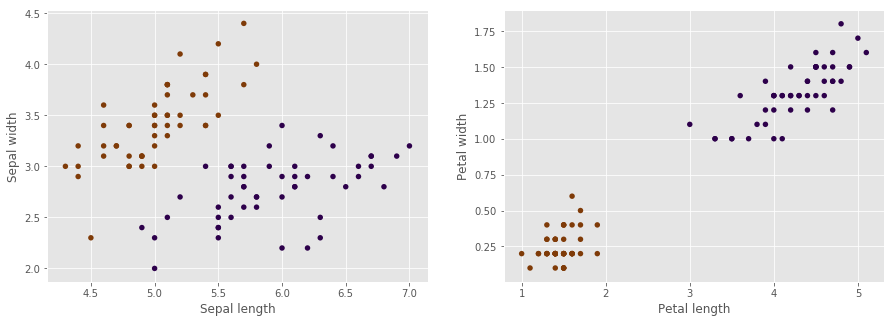

In [11]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(15, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.show()

In [12]:
CL_iris = Clustering(linkage='single', k=2)
CL_iris.fit(x_iris)
y_ir = CL_iris.predict()

pl.figure(figsize=(15, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_ir, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_ir, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

In [13]:
#CL = Clustering(k=2, linkage='single')
pred_iris = Clustering(k=2, linkage='single').fit_predict(x_iris)
print "Single: Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

pred_iris = Clustering(k=2, linkage='complete').fit_predict(x_iris)
print "Complete: Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

pred_iris = Clustering(k=2, linkage='average').fit_predict(x_iris)
print "Average: Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Single: Adjusted Rand index for iris is: 1.00
Complete: Adjusted Rand index for iris is: 1.00
Average: Adjusted Rand index for iris is: 1.00


## 3. Реальные данные

In [14]:
import pandas as pd
df = pd.read_csv("csv/WDIData.csv")

In [15]:
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,Unnamed: 61
0,Arab World,ARB,"2005 PPP conversion factor, GDP (LCU per inter...",PA.NUS.PPP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"2005 PPP conversion factor, private consumptio...",PA.NUS.PRVT.PP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,82.831932,83.474617,84.006076,84.416148,84.734574,85.003645,85.244971,NaN,NaN,NaN
3,Arab World,ARB,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,85.042248,84.655338,85.955345,86.392313,86.846966,87.604961,88.039125,NaN,NaN,NaN
4,Arab World,ARB,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,72.292323,71.765345,73.734266,74.500717,75.218497,76.712250,77.407269,NaN,NaN,NaN


In [16]:
df1 = df[['Country Name', 'Indicator Code', '2012']]
df1 = df1.set_index(['Country Name', 'Indicator Code'])
df1 = df1.unstack()
df1 -= df1.mean()
df1 /= df1.std()
df1 = df1['2012']
df1 = df1.fillna(0)


df1  = df1[df1.columns[(df1 ** 2).sum() > 200]]
df1.head()

Indicator Code,AG.CON.FERT.ZS,AG.LND.AGRI.K2,AG.LND.AGRI.ZS,AG.LND.ARBL.HA,AG.LND.ARBL.HA.PC,AG.LND.ARBL.ZS,AG.LND.CREL.HA,AG.LND.CROP.ZS,AG.LND.FRST.K2,AG.LND.FRST.ZS,...,TX.VAL.MRCH.R3.ZS,TX.VAL.MRCH.R4.ZS,TX.VAL.MRCH.R5.ZS,TX.VAL.MRCH.R6.ZS,TX.VAL.MRCH.RS.ZS,TX.VAL.MRCH.WL.CD,TX.VAL.OTHR.ZS.WT,TX.VAL.SERV.CD.WT,TX.VAL.TRAN.ZS.WT,TX.VAL.TRVL.ZS.WT
Country Name,,,,,,,,,,,,,,,,,,,,,
Afghanistan,-0.232922,-0.277925,0.987333,0.048861,0.205310,-0.141932,-0.320358,-0.529408,-0.324259,-1.307388,...,-0.502358,0.092388,7.864791,-0.444221,-0.511625,-0.321074,2.099861,-0.282628,-0.548673,-1.444091
Albania,-0.163369,-0.341607,0.294204,-0.303700,0.035305,0.697972,-0.352974,-0.163853,-0.325429,-0.144543,...,-0.526043,-0.329151,-0.528477,-0.501426,-0.485530,-0.320371,-0.253742,-0.280754,-0.744884,0.867797
Algeria,-0.239678,-0.271873,-0.995209,0.034923,-0.022170,-0.833564,-0.321234,-0.500955,-0.323073,-1.363153,...,-0.028766,0.220767,-0.396764,-0.486755,-0.511393,-0.286537,1.756397,-0.278551,-0.141292,-1.536833
American Samoa,0.000000,-0.343683,-0.648340,-0.333990,-0.635704,0.099724,0.000000,0.769064,-0.326968,2.516295,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Andorra,0.000000,-0.343656,0.252087,-0.334020,-0.741975,-0.679593,0.000000,0.000000,-0.326971,0.112072,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
#Кластеризация
model = Clustering(k=8, linkage='average')
mylabels = model.fit_predict(df1.values)

In [18]:
mydict = {}
for i, label in enumerate(set(mylabels)):
    mydict.update({label : i + 1})
for i in xrange(mylabels.shape[0]):
    mylabels[i] = mydict[mylabels[i]]

In [19]:
# Вывод стран по кластерам
pd.options.mode.chained_assignment = None
df1.loc[:, 'label'] = mylabels

for label, group in df1.groupby('label'):
    print('Cluster #{}'.format(label))    
    print(group.index.tolist())
    print('='*20)

Cluster #1
['Cyprus', 'Hong Kong SAR, China', 'Iceland', 'Luxembourg', 'Macao SAR, China', 'Malta', 'Singapore']
Cluster #2
['Afghanistan', 'Angola', 'Benin', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Djibouti', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia, The', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Indonesia', 'Iraq', 'Kenya', 'Kiribati', 'Korea, Dem. People\xe2\x80\x99s Rep.', 'Lao PDR', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Micronesia, Fed. Sts.', 'Mozambique', 'Namibia', 'Nepal', 'Niger', 'Nigeria', 'Papua New Guinea', 'Rwanda', 'Samoa', 'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'Solomon Islands', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Swaziland', 'Tajikistan', 'Tanzania', 'Togo', 'Tonga', 'Uganda', 'Vanuatu', 'Vietnam', 'West Bank and Gaza', 'Yemen, Rep.', 'Zambia', 'Zimbabwe']
Cluster #3
['Suriname']
Clust

In [20]:
#На плоскости
from sklearn.manifold import TSNE
transform = TSNE(n_components=2)
embedded = transform.fit_transform(df1.values)


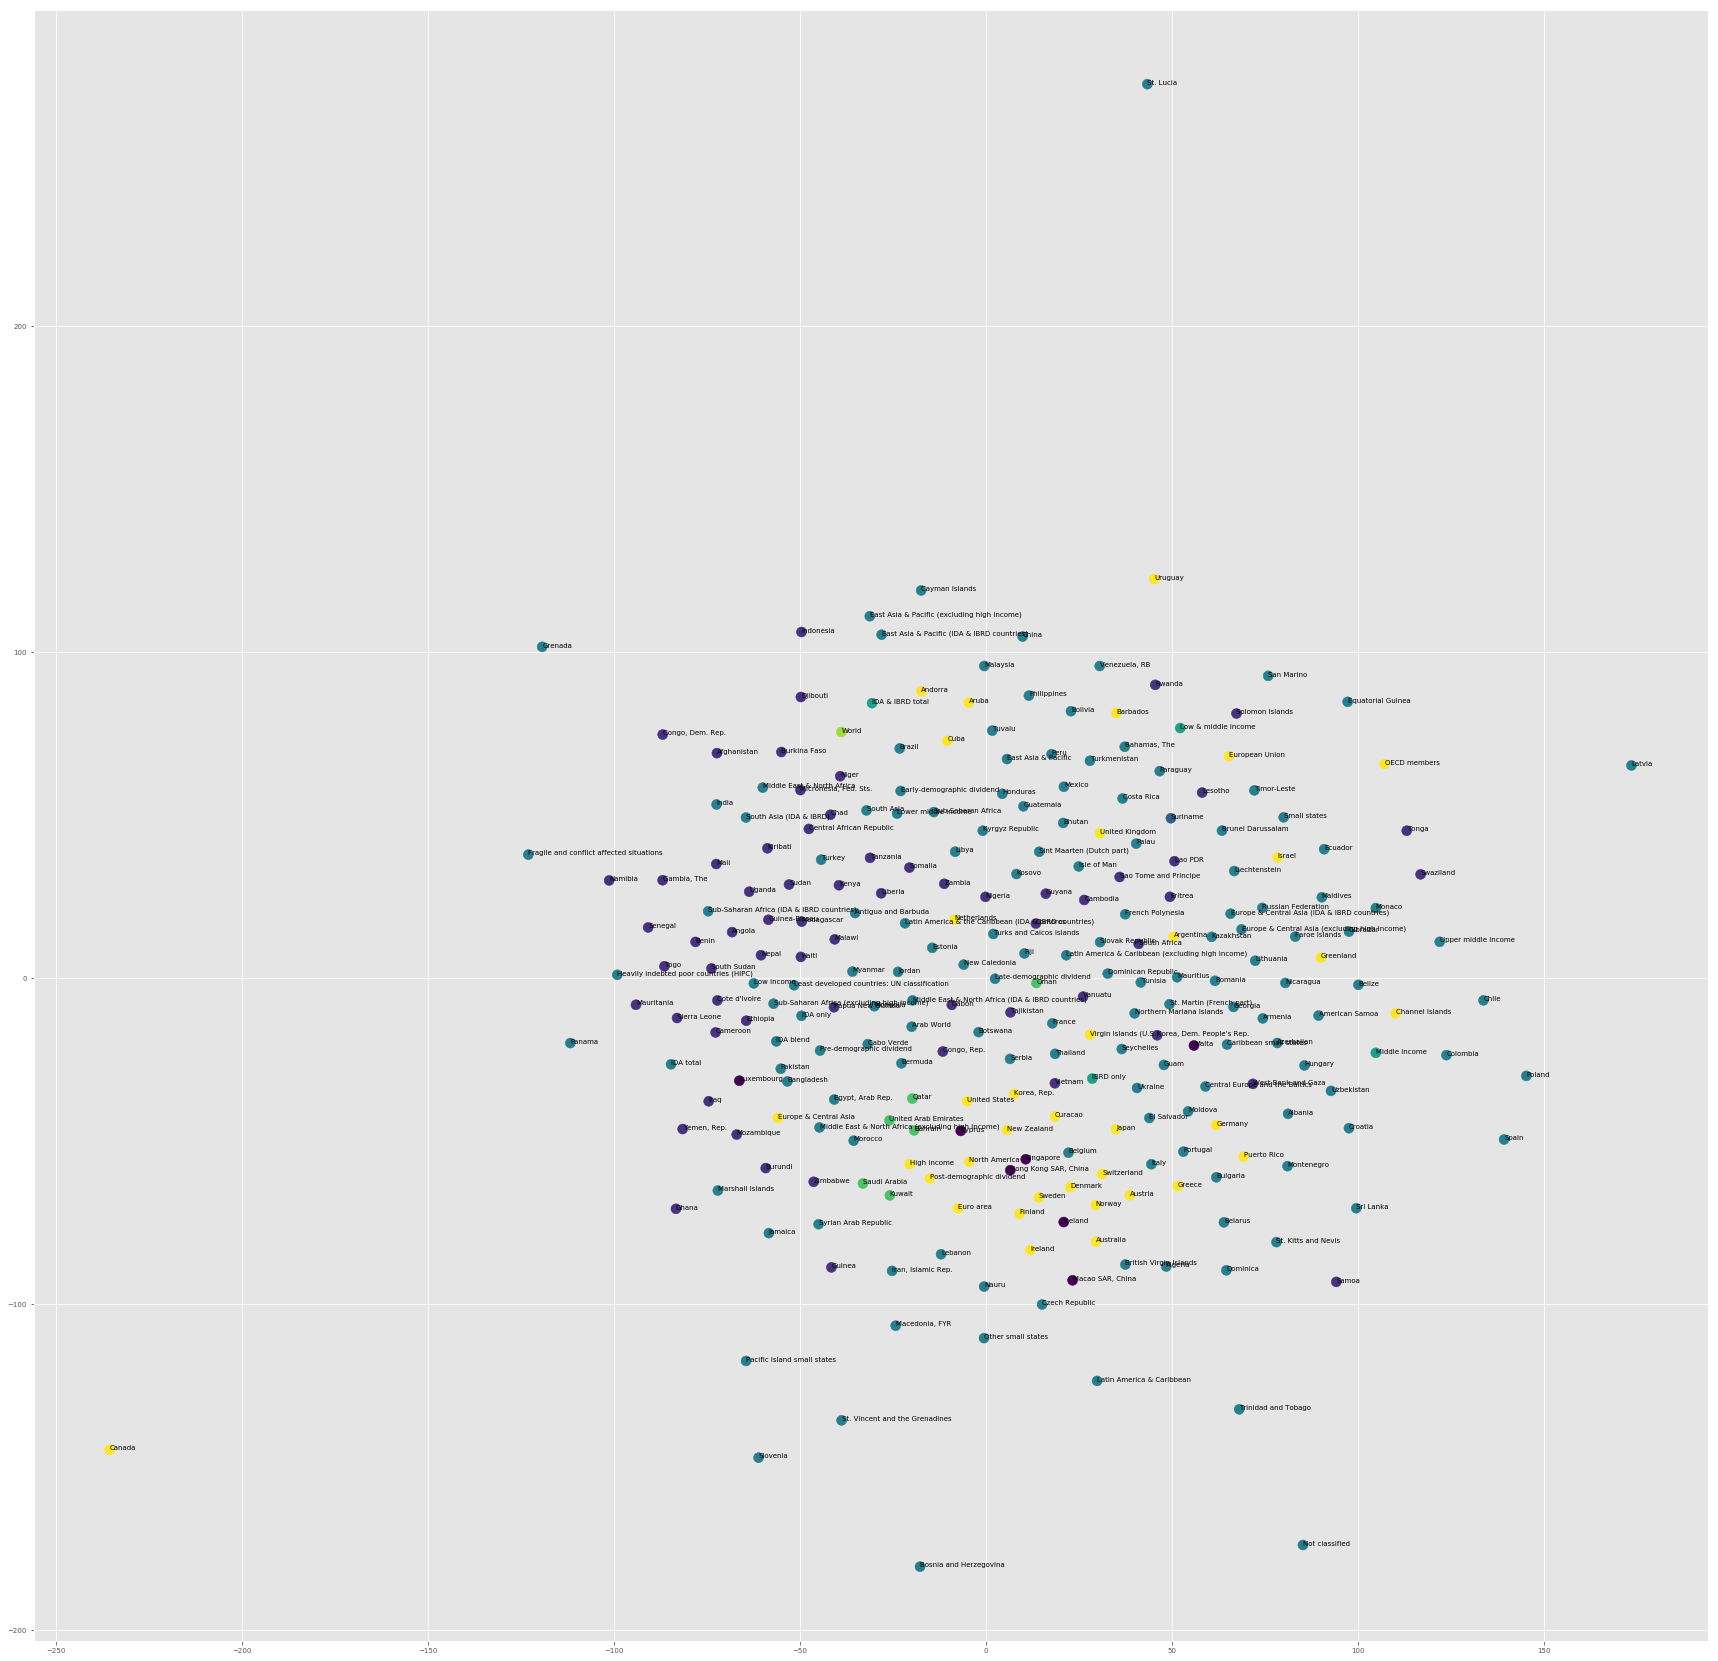

In [21]:
import sys
reload(sys)
sys.setdefaultencoding('UTF8')

plt.figure(figsize=(30,30))
matplotlib.rcParams.update({'font.size': 7})

plt.scatter(embedded[:,0], embedded[:,1], c=mylabels,  s=100)
for i in xrange(df1.shape[0]):
    print(df1.index[i])
    plt.annotate(str(df1.index[i]), xy = embedded[i])
plt.show()

## 4.Вывод

Разбиение на кластеры объясняется уровнем жизни,богатством,образованностью населения страны:<br/>
Кластер #1: Очень маленькие, но развитые и богатые страны или регионы<br/>
Кластер #2: Беднейшие и наименее развитые страны, в основном африканские<br/>
Кластер #4: Большинство стран имеют средний уровень развития и грамотности населения<br/>
Кластер #6: Страны Персидского залива<br/>
Кластер #8: Богатые, развитые страны и Куба<br/>